In [16]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the CSV file
df = pd.read_csv('p_data50000.csv')




In [17]:
df.tail()

,id,gender,age,topic,sign,date,text,Word_count
49833,1673216,male,17,Student,Taurus,"03,May,2004",one morn got bed check phone someon knock door...,241
49834,1673216,male,17,Student,Taurus,"13,June,2004",edit proof http img35 photobucket com album v1...,265
49835,1673216,male,17,Student,Taurus,"30,July,2004",human heart heart collect particl molecul atom...,238
49836,4260903,female,34,indUnk,Virgo,"23,August,2004",ran around clean morn grandma mom dad come 11a...,214
49837,4260903,female,34,indUnk,Virgo,"18,August,2004",want consid rawfoodist ye like make one word l...,282


In [18]:
# Assume the CSV has columns 'text' and 'label'
texts = df['text'].tolist()
labels = df['gender'].tolist()

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Hyperparameters
vocab_size = 20000
max_length = 300  # Adjust based on your data
embedding_dim = 100  # Size of GloVe vectors

# Tokenization and padding
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
X = pad_sequences(sequences, maxlen=max_length)
y = np.array(labels)

print(df['gender'].value_counts())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


female    26041
male      23797
Name: gender, dtype: int64


In [19]:
# Handle class imbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print("Class Weights: ", class_weights)

Class Weights:  {0: 0.9572629051620648, 1: 1.046731425571016}


In [20]:
# Load GloVe embeddings
embedding_index = {}
glove_path = 'glove/glove.twitter.27B.100d.txt'  # Update with the path to your GloVe file

with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Create an embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
       



In [21]:



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

# Build the model with increased complexity
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)
]

# Train the model with class weights for more epochs
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks, class_weight=class_weights)


Epoch 1/30
997/997 [==============================] - 427s 425ms/step - loss: 0.6756 - accuracy: 0.5795 - val_loss: 0.6666 - val_accuracy: 0.6023
Epoch 2/30


/Users/abhaydevraj/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


997/997 [==============================] - 627s 629ms/step - loss: 0.6596 - accuracy: 0.6121 - val_loss: 0.6445 - val_accuracy: 0.6551
Epoch 3/30
997/997 [==============================] - 590s 592ms/step - loss: 0.6409 - accuracy: 0.6427 - val_loss: 0.6273 - val_accuracy: 0.6611
Epoch 4/30
997/997 [==============================] - 566s 568ms/step - loss: 0.6236 - accuracy: 0.6614 - val_loss: 0.6111 - val_accuracy: 0.6811
Epoch 5/30
997/997 [==============================] - 590s 591ms/step - loss: 0.6126 - accuracy: 0.6700 - val_loss: 0.6039 - val_accuracy: 0.6852
Epoch 6/30
997/997 [==============================] - 598s 600ms/step - loss: 0.6070 - accuracy: 0.6804 - val_loss: 0.6096 - val_accuracy: 0.6825
Epoch 7/30
997/997 [==============================] - 596s 598ms/step - loss: 0.5937 - accuracy: 0.6905 - val_loss: 0.5875 - val_accuracy: 0.6986
Epoch 8/30
997/997 [==============================] - 624s 626ms/step - loss: 0.5877 - accuracy: 0.6976 - val_loss: 0.5864 - val_accura

KeyboardInterrupt: 

312/312 [==============================] - 36s 115ms/step - loss: 0.6109 - accuracy: 0.6553
Test Accuracy: 0.6552969217300415
312/312 [==============================] - 36s 115ms/step
F1 Score: 0.6453627650134457
Precision: 0.6883837081692107
Recall: 0.6552969502407705
Confusion Matrix:
[[2537 2679]
 [ 757 3995]]
Classification Report:
              precision    recall  f1-score   support

      female       0.77      0.49      0.60      5216
        male       0.60      0.84      0.70      4752

    accuracy                           0.66      9968
   macro avg       0.68      0.66      0.65      9968
weighted avg       0.69      0.66      0.65      9968



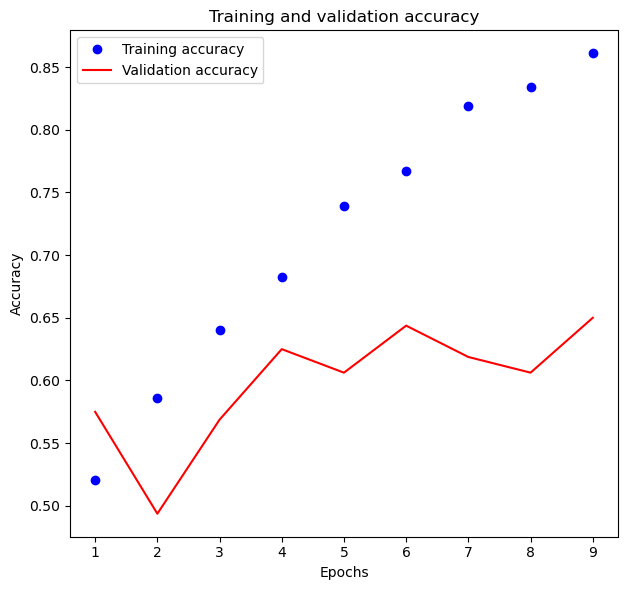

In [24]:
# Evaluate the model
import matplotlib.pyplot as plt
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

# Predict on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute metrics
f1 = f1_score(y_test, y_pred_classes, average='weighted')
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred_classes)
class_report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

# Plot training and validation accuracy and loss
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

